In [117]:
import gzip
import math
import numpy
import pandas as pd
import random
import sklearn
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from collections import defaultdict
# from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
import gensim
from gensim.models import Word2Vec

In [82]:
import warnings
warnings.filterwarnings("ignore")

In [83]:
def calcuate_accuracy_score(y_true, predictions):
    assert len(y_true) == len(predictions), "number of predictions does not equal original set length"
    numTotal = len(predictions)
    numCorrect = numpy.count_nonzero(numpy.array(y_true) == numpy.array(predictions))
    return numCorrect / numTotal

In [84]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

Exploratory Analysis/Data Preprocessing

In [85]:
df = pd.read_csv("HateSpeechDataset.csv")

# Extract the needed columns
df = df[['Content', 'Label']]

df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [86]:
df['Label'].value_counts()

0        361594
1         79305
Label         7
Name: Label, dtype: int64

In [87]:
df['Content'].str.len().describe()

count    440906.000000
mean        226.116034
std         277.813386
min           1.000000
25%          62.000000
50%         119.000000
75%         269.000000
max        9998.000000
Name: Content, dtype: float64

In [88]:
df_short_not_too_short = df[df.Label != "Label"]

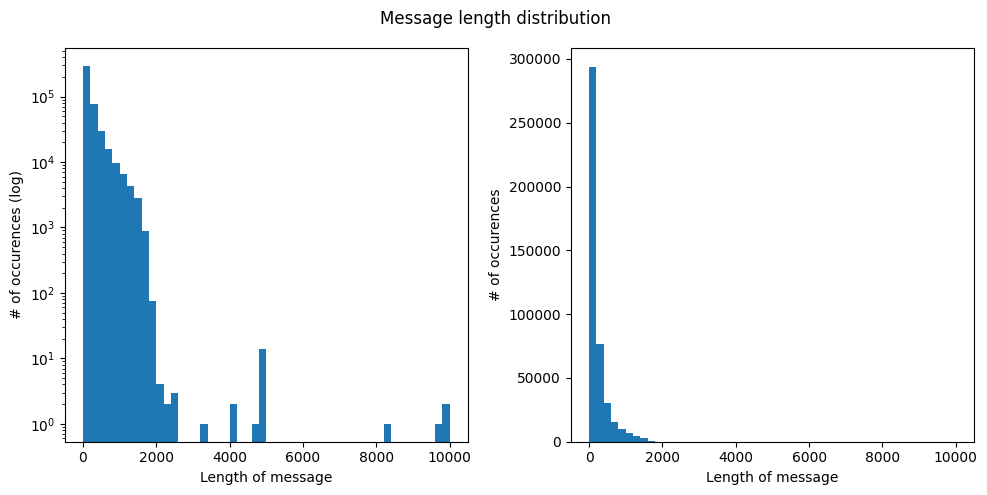

In [89]:
sentence_lengths = df_short_not_too_short['Content'].str.len()
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), tight_layout=True)
axs[0].hist(sentence_lengths.to_numpy(), bins=50, log=True)
axs[1].hist(sentence_lengths.to_numpy(), bins=50, log=False)
axs[0].set_ylabel("# of occurences (log)")
axs[0].set_xlabel("Length of message")
axs[1].set_ylabel("# of occurences")
axs[1].set_xlabel("Length of message")
fig.suptitle("Message length distribution")
plt.show()

In [90]:
df_short_not_too_short['Label'].value_counts()

0    361594
1     79305
Name: Label, dtype: int64

In [91]:
df_short_not_too_short['Content'].str.len().describe()

count    440899.000000
mean        226.119513
std         277.814219
min           1.000000
25%          62.000000
50%         119.000000
75%         269.000000
max        9998.000000
Name: Content, dtype: float64

In [92]:
df_short_not_too_short = df_short_not_too_short[df_short_not_too_short['Content'].str.len() < 300]
df_short_not_too_short = df_short_not_too_short[df_short_not_too_short['Content'].str.len() > 1]

In [93]:
df.sort_values(by="Content",inplace=False, key=lambda str: str.str.len())

,Content,Label
50643,t,1
115940,v,0
409476,e,0
32762,a,1
105203,p,0
...,...,...
398828,do not change it zzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,0
40448,wsdfjneurovbnerpivijervnerovohjewrvnrnrvrejfir...,1
376512,you are fucking gay wad i fucked your mum oh w...,1
337241,gaaaaaaaaaaaaaaaaaaaaaaaaay you are fucking ga...,1


In [94]:
df_short_not_too_short['Label'].value_counts()

0    271100
1     72279
Name: Label, dtype: int64

In [95]:
271100 / ( 271100+72279)

0.7895066384374118

In [96]:
df_short_not_too_short['Content'].str.len().describe()

count    343379.000000
mean        108.869098
std          72.442309
min           2.000000
25%          51.000000
50%          91.000000
75%         150.000000
max         299.000000
Name: Content, dtype: float64

In [97]:
len(df.iloc[378972].get("Content"))

9998

In [98]:
random_state = 42

In [99]:
df_train, df_valid = train_test_split(df_short_not_too_short, test_size=0.5, random_state=random_state)  # 50% train, 25% validation, 25% test
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=random_state)


Training & Testing Models

0) Random Choice -> 0.5
1) BoW N most common words -> 0.8299183430987688
2) BoW N most common TF-IDF -> 0.828528161220805
3) latent semantic analysis (word2vec w/ Logistic) -> 0.8169025569340089
4) word2vec w/ AdaBoost -> 0.8239967383074145


In [100]:
df_train = df_train.to_numpy()
df_valid = df_valid.to_numpy()
df_test = df_test.to_numpy()

Build and train bag of words N most popular words model

In [101]:
sp = set(string.punctuation)
wordCount = defaultdict(int)
for (sentence, label) in df_train:
    r = ''.join([c for c in sentence.lower() if not c in sp])
    for w in r.split():
        wordCount[w] += 1


In [102]:
stopWords = stopwords.words("english")
counts = [(wordCount[x], x) for x in wordCount if not x in stopWords]
counts.sort()
counts.reverse()
counts

[(14529, 'slut'),
 (12749, 'like'),
 (11410, 'article'),
 (10615, 'page'),
 (10328, 'would'),
 (9657, 'please'),
 (9345, 'people'),
 (9112, 'whatever'),
 (8711, 'one'),
 (8652, 'talk'),
 (8267, 'see'),
 (7824, 'know'),
 (7612, 'think'),
 (7251, 'get'),
 (6648, 'thanks'),
 (6527, 'wikipedia'),
 (6471, 'bitch'),
 (6388, 'face'),
 (5775, 'retweet'),
 (5719, 'want'),
 (5634, 'fuck'),
 (5539, 'good'),
 (5170, 'time'),
 (5105, 'go'),
 (4725, 'fucking'),
 (4646, 'edit'),
 (4587, 'love'),
 (4434, 'make'),
 (4257, 'also'),
 (4237, 'going'),
 (4145, 'stop'),
 (4127, 'well'),
 (4050, 'cannot'),
 (4018, 'us'),
 (3983, 'new'),
 (3977, 'need'),
 (3967, 'really'),
 (3947, 'could'),
 (3758, 'say'),
 (3744, 'right'),
 (3718, 'back'),
 (3704, 'thank'),
 (3558, 'even'),
 (3528, 'much'),
 (3527, 'look'),
 (3440, 'got'),
 (3403, 'use'),
 (3337, 'women'),
 (3255, 'take'),
 (3210, 'day'),
 (3129, 'let'),
 (3064, 'ass'),
 (3034, 'shit'),
 (3014, 'still'),
 (2980, 'user'),
 (2970, 'black'),
 (2953, 'blocked'),

In [103]:
def featureCountN(datum, wordsN, wordIdN):
    feat = [0]*len(wordsN)
    r = ''.join([c for c in datum.lower() if not c in sp])
    for w in r.split():
        if w in wordsN:
            feat[wordIdN[w]] += 1
    feat.append(1) # offset
    return feat

def trainModelCounts(dictSize, reg_C, trainSet, validSet):
    wordsN = [x[1] for x in counts[:dictSize]]
    wordIdN = dict(zip(wordsN, range(len(wordsN))))

    X_train = [featureCountN(sentence, wordsN, wordIdN) for (sentence,_) in trainSet]
    y_train = [label for (_,label) in trainSet]

    X_valid = [featureCountN(sentence, wordsN, wordIdN) for (sentence,_) in validSet]
    y_valid = [label for (_,label) in validSet]

    # X_test = [featureCountN(sentence, wordsN, wordIdN) for (sentence,_) in testSet]
    # y_test = [label for (_,label) in testSet]
    mod = linear_model.LogisticRegression(C=reg_C, random_state=random_state)
    mod.fit(X_train,y_train)
    pred_valid = mod.predict(X_valid)
    correct = pred_valid == y_valid
    return (numpy.sum(correct) / len(correct), mod)

def trainModel_BoWPop(dictSize, reg_C, trainSet):
    wordsN = [x[1] for x in counts[:dictSize]]
    wordIdN = dict(zip(wordsN, range(len(wordsN))))

    X_train = [featureCountN(sentence, wordsN, wordIdN) for (sentence,_) in trainSet]
    y_train = [label for (_,label) in trainSet]

    mod = linear_model.LogisticRegression(C=reg_C, random_state=random_state)
    mod.fit(X_train,y_train)
    return mod

In [17]:
dictionarySizes = numpy.arange(start=100, stop=1501, step=100)
reg_constants = numpy.arange(start=0.1, stop=1.51, step=0.1)

In [19]:
best_acc_bow_count = 0
best_dict_size_bow_count = 0
best_reg_bow_count = 0

In [113]:
best_model_bow_count = 0

In [ ]:

# for dictSize in dictionarySizes:
#     for reg in reg_constants:
#         acc = trainModelCounts(dictSize, reg, df_train, df_valid)
#         if (acc > best_acc_bow_count):
#             best_acc_bow_count = acc
#             best_dict_size_bow_count = dictSize
#             best_reg_bow_count = reg
#         print((dictSize, reg, acc, acc > best_acc_bow_count))

for dictSize in dictionarySizes:
    (acc, model) = trainModelCounts(dictSize, 1, df_train, df_valid)
    improved = False
    if (acc > best_acc_bow_count):
        improved = True
        best_acc_bow_count = acc
        best_dict_size_bow_count = dictSize
        best_reg_bow_count = 1
        best_model_bow_count = model
    print((dictSize, best_reg_bow_count, acc, improved))

(100, 1, 0.7945390583137246, True)
(200, 1, 0.797521142511008, True)
(300, 1, 0.8024252731635719, True)
(400, 1, 0.8087389045500082, True)
(500, 1, 0.8129091629196468, True)
(600, 1, 0.8159844372480954, True)
(700, 1, 0.8206322950399553, True)
(800, 1, 0.8220068494746406, True)
(900, 1, 0.8229154532535005, True)
(1000, 1, 0.8244996854833073, True)
(1100, 1, 0.8262004053770706, True)
(1200, 1, 0.8270041702583696, True)
(1300, 1, 0.8280991542995597, True)
(1400, 1, 0.8296134939309927, True)
(1500, 1, 0.8302075810171703, True)


In [116]:
for reg in reg_constants:
    (acc, model) = trainModelCounts(best_dict_size_bow_count, reg, df_train, df_valid)
    improved = False
    if (acc > best_acc_bow_count):
        improved = True
        best_acc_bow_count = acc
        best_dict_size_bow_count = best_dict_size_bow_count
        best_reg_bow_count = reg
        best_model_bow_count = model
    print((best_dict_size_bow_count, reg, acc, improved))

(1500, 0.1, 0.8294717222901742, True)
(1500, 0.2, 0.8302289009260877, True)
(1500, 0.30000000000000004, 0.8302289009260877, False)
(1500, 0.4, 0.8303453899469975, True)
(1500, 0.5, 0.8303803366532704, True)
(1500, 0.6, 0.8304735278699983, True)
(1500, 0.7000000000000001, 0.8303919855553614, False)
(1500, 0.8, 0.8305084745762712, True)
(1500, 0.9, 0.8304269322616343, False)
(1500, 1.0, 0.8304152833595434, False)
(1500, 1.1, 0.8304618789679072, False)
(1500, 1.2000000000000002, 0.8303803366532704, False)
(1500, 1.3000000000000003, 0.8302405498281787, False)
(1500, 1.4000000000000001, 0.8303104432407246, False)
(1500, 1.5000000000000002, 0.8304152833595434, False)


In [106]:
# final hyperparameters
best_dict_size_bow_count = 1500
best_reg_bow_count = 0.8
best_acc_bow_count = 0.8305084745762712

In [117]:
BoWModel = trainModel_BoWPop(best_dict_size_bow_count, best_reg_bow_count, df_train)

In [118]:
from joblib import dump
with open("bag_of_words_N_pop.pkl", "wb") as f:
    dump(BoWModel, f, protocol=5)

In [185]:
import joblib
BoWModel = joblib.load("bag_of_words_N_pop.pkl")

In [120]:
# run final model on test set
wordsN = [x[1] for x in counts[:best_dict_size_bow_count]]
wordIdN = dict(zip(wordsN, range(len(wordsN))))
X_test = [featureCountN(sentence, wordsN, wordIdN) for (sentence,_) in df_test]
y_test = [label for (_,label) in df_test]
y_pred = BoWModel.predict(X_test)
correct = y_pred == y_test
correct

array([ True,  True,  True, ...,  True,  True,  True])

In [190]:
temp = BoWModel.coef_
print(temp)
numpy.argmax(temp)
temp[:1,499]
top10 = numpy.flip(numpy.argsort(temp)[0][-50:])
for id in top10:
    for (word, idx) in wordIdN.items():
        if (id == idx):
            print(word)


[[-0.16808078  0.11940327 -0.7997109  ... -0.17496671 -0.04581227
  -0.5565175 ]]
shithole
sexist
retard
faggot
idiot
moron
retarded
nigger
gays
suck
asshole
muslims
dickhead
trans
afro
vagina
blacks
motherfucker
immigrants
kat
pathetic
buildthatwall
douchebag
fag
idiots
islam
fool
cock
cunt
loser
f
ti
stupid
indians
jews
chinese
whore
women
trumpisatraitor
liar
peter
dumb
penis
disabled
ignorant
jew
dick
illegal
gay
fuck


In [121]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label="1"))
print('Recall:', recall_score(y_test, y_pred, pos_label="1"))
print('F1 score:', f1_score(y_test, y_pred, pos_label="1"))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.8285631079270779
Precision: 0.6630522902310498
Recall: 0.3648173961527739
F1 score: 0.47066863288134375
Balanced Accuracy: 0.6579277674328882


In [122]:
numpy.sum(correct) / len(correct)

0.8285631079270779

Build and train bag of words N highest TF-IDF model

In [113]:
df = defaultdict(int)
for (sentence, label) in df_train:
    r = ''.join([c for c in sentence.lower() if not c in sp])
    for w in set(r.split()):
        df[w] += 1

In [112]:
dictionarySizes = numpy.arange(start=500, stop=1501, step=100)
reg_constants = numpy.arange(start=0.5, stop=1.51, step=0.1)

def featureTFIDF_N(datum, wordsN, wordIdN):
    feat = [0]*len(wordsN)
    r = ''.join([c for c in datum.lower() if not c in sp])

    tf = defaultdict(int)
    for w in r.split():
    # Note = rather than +=, different versions of tf could be used instead
        tf[w] += 1
    tfidf = dict(zip(wordsN,[tf[w] * math.log10(len(df_train) / df[w]) for w in wordsN]))
    for w in wordsN:
        feat[wordIdN[w]] = tfidf[w]
    feat.append(1) # offset
    return feat

def trainModelTFIDF(dictSize, reg_C, trainSet, validSet):
    wordsN = [x[1] for x in counts[:dictSize]]
    wordIdN = dict(zip(wordsN, range(len(wordsN))))

    X_train = [featureTFIDF_N(sentence, wordsN, wordIdN) for (sentence,_) in trainSet]
    y_train = [label for (_,label) in trainSet]

    X_valid = [featureTFIDF_N(sentence, wordsN, wordIdN) for (sentence,_) in validSet]
    y_valid = [label for (_,label) in validSet]

    mod = linear_model.LogisticRegression(C=reg_C, random_state=random_state)
    mod.fit(X_train,y_train)
    pred = mod.predict(X_valid)
    correct = y_valid == pred
    return (numpy.sum(correct) / len(correct), mod)

In [21]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

# best_acc_TFIDF = 0
# best_dict_size_TFIDF = 0
# best_reg_TFIDF = 0
# best_model_TFIDF = 0

dictionarySizes = numpy.arange(start=100, stop=1501, step=100)
reg_constants = numpy.arange(start=0.1, stop=1.51, step=0.1)

In [ ]:
for dictSize in dictionarySizes:
    acc, model = trainModelTFIDF(dictSize, 1, df_train, df_valid)
    improved = False
    if (acc > best_acc_TFIDF):
        improved = True
        best_acc_TFIDF = acc
        best_dict_size_TFIDF = dictSize
        best_model_TFIDF = model
        best_reg_TFIDF = 1
    print((acc, dictSize, 1, improved))

for reg in reg_constants:
    acc, model = trainModelTFIDF(best_dict_size_TFIDF, reg, df_train, df_valid)
    improved = False
    if (acc > best_acc_TFIDF):
        improved = True
        best_acc_TFIDF = acc
        best_dict_size_TFIDF = best_dict_size_TFIDF
        best_model_TFIDF = model
        best_reg_TFIDF = reg
    print((acc, best_dict_size_TFIDF, reg, improved))

(0.7944691657153508, 100, 1, True)
(0.7974861962118212, 200, 1, True)
(0.8023670293315938, 300, 1, True)
(0.8087622020827995, 400, 1, True)
(0.812839270321273, 500, 1, True)
(0.8159494909489086, 600, 1, True)
(0.8206439438063509, 700, 1, True)
(0.8219602544090581, 800, 1, True)
(0.8231367798150175, 900, 1, True)
(0.8245113342497029, 1000, 1, True)
(0.8262702979754444, 1100, 1, True)
(0.8269808727255784, 1200, 1, True)
(0.8282738857954942, 1300, 1, True)
(0.8295901963982014, 1400, 1, True)
(0.8302425273163572, 1500, 1, True)
(0.8300328495212357, 1500, 0.1, True)
(0.8302308785499616, 1500, 0.2, True)
(0.8302774736155442, 1500, 0.30000000000000004, True)
(0.8302192297835659, 1500, 0.4, True)
(0.8302541760827529, 1500, 0.5, True)


(0.7944691657153508, 100, 1, True)
(0.7974861962118212, 200, 1, True)
(0.8023670293315938, 300, 1, True)
(0.8087622020827995, 400, 1, True)
(0.812839270321273, 500, 1, True)
(0.8159494909489086, 600, 1, True)
(0.8206439438063509, 700, 1, True)
(0.8219602544090581, 800, 1, True)
(0.8231367798150175, 900, 1, True)
(0.8245113342497029, 1000, 1, True)
(0.8262702979754444, 1100, 1, True)
(0.8269808727255784, 1200, 1, True)
(0.8282738857954942, 1300, 1, True)
(0.8295901963982014, 1400, 1, True)
(0.8302425273163572, 1500, 1, True)
(0.8300328495212357, 1500, 0.1, True)
(0.8302308785499616, 1500, 0.2, True)
(0.8302774736155442, 1500, 0.30000000000000004, True)
(0.8302192297835659, 1500, 0.4, True)
(0.8302541760827529, 1500, 0.5, True)

In [ ]:
for reg in reg_constants:
    acc, model = trainModelTFIDF(best_dict_size_TFIDF, reg, df_train, df_valid)
    improved = False
    if (acc > best_acc_TFIDF):
        improved = True
        best_acc_TFIDF = acc
        best_dict_size_TFIDF = best_dict_size_TFIDF
        best_model_TFIDF = model
        best_reg_TFIDF = reg
    print((acc, best_dict_size_TFIDF, reg, improved))

(0.8303453899469975, 1500, 0.5, True)
(0.8303686877511794, 1500, 0.6, True)
(0.8303919855553614, 1500, 0.7, True)
(0.8303919855553614, 1500, 0.7999999999999999, False)


In [46]:
for reg in [0.1, 0.2, 0.3, 0.4, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]:
    acc, model = trainModelTFIDF(best_dict_size_TFIDF, reg, df_train, df_valid)
    improved = False
    if (acc > best_acc_TFIDF):
        improved = True
        best_acc_TFIDF = acc
        best_dict_size_TFIDF = best_dict_size_TFIDF
        best_model_TFIDF = model
        best_reg_TFIDF = reg
    print((acc, best_dict_size_TFIDF, reg, improved))

(0.8304851767720892, 1500, 0.1, True)
(0.8304502300658163, 1500, 0.2, False)
(0.8303220921428155, 1500, 0.3, False)
(0.8303220921428155, 1500, 0.4, False)
(0.8304036344574524, 1500, 0.9, False)
(0.8304269322616343, 1500, 1.0, False)
(0.8304502300658163, 1500, 1.1, False)
(0.8304618789679072, 1500, 1.2, False)
(0.8304618789679072, 1500, 1.3, False)
(0.8304618789679072, 1500, 1.4, False)
(0.8304735278699983, 1500, 1.5, False)


In [110]:
# final TFIDF hyperparameters
best_dict_size_TFIDF = 1500
best_reg_TFIDF = 0.1
best_acc_TFIDF = 0.8304851767720892

In [51]:
from joblib import dump
with open("bag_of_words_N_TFIDF.pkl", "wb") as f:
    dump(best_model_TFIDF, f, protocol=5)

In [109]:
import joblib
best_model_TFIDF = joblib.load("bag_of_words_N_TFIDF.pkl")

In [191]:
temp = best_model_TFIDF.coef_
print(temp)
numpy.argmax(temp)
temp[:1,499]
top10 = numpy.flip(numpy.argsort(temp)[0][-50:])
for id in top10:
    for (word, idx) in wordIdN.items():
        if (id == idx):
            print(word)


[[-0.14856483  0.10127752 -0.62906417 ... -0.06073759 -0.01532128
  -0.02071973]]
sexist
shithole
retard
faggot
idiot
retarded
nigger
moron
suck
muslims
vagina
asshole
gays
trans
immigrants
blacks
women
kat
fuck
afro
stupid
dickhead
islam
motherfucker
pathetic
buildthatwall
fag
black
jews
idiots
douchebag
f
cunt
cock
fool
chinese
penis
loser
gay
dumb
ti
whore
trumpisatraitor
indians
illegal
liar
muslim
fucking
disabled
peter


In [115]:
# run final model on test set
wordsN = [x[1] for x in counts[:best_dict_size_TFIDF]]
wordIdN = dict(zip(wordsN, range(len(wordsN))))
X_test = [featureTFIDF_N(sentence, wordsN, wordIdN) for (sentence,_) in df_test]
y_test = [label for (_,label) in df_test]
y_pred = best_model_TFIDF.predict(X_test)
correct = y_pred == y_test
correct

array([ True,  True,  True, ...,  True,  True,  True])

In [119]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label="1"))
print('Recall:', recall_score(y_test, y_pred, pos_label="1"))
print('F1 score:', f1_score(y_test, y_pred, pos_label="1"))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.828528161220805
Precision: 0.6634801179701006
Recall: 0.363758015054363
F1 score: 0.46989340247767225
Balanced Accuracy: 0.6575158798582079


In [54]:
numpy.sum(correct) / len(correct)

0.828528161220805

word2vec LogisticRegression

In [18]:
sentenceTokens = []
punctuation = set(string.punctuation)
for (sentence,label) in df_train:
    r = ''.join([c for c in sentence.lower() if not c in punctuation])
    tokens = []
    for w in r.split():
        tokens.append(w)
    sentenceTokens.append(tokens)

In [39]:
min_count_list = numpy.arange(start=1, stop=21, step=1)
vector_size_list = numpy.arange(start=5, stop=156, step=5)
window_list = numpy.arange(start=1, stop=21, step=1)
alpha_list = numpy.arange(start=0.001, stop=0.03, step=0.001)
negative_list = numpy.arange(start=1, stop=21, step=1)
hs_list = numpy.arange(start=0, stop=2, step=1)
sg_list = numpy.arange(start=0, stop=2, step=1)
reg_list = numpy.arange(start=0.1, stop=1.51, step=0.1)

In [38]:
best_vector_size_logistic = 100
best_min_count_logistic = 2
best_window_logistic = 3
best_alpha_logistic = 0.01
best_negative_logistic = 5
best_hs_logistic = 1
best_sg_logistic = 1
best_reg_logistic = 1
best_acc_logistic = 0
best_w2v_model = 0
best_w2v_logistic_model = 0

In [123]:
def vectorize(sentence, model, vector_size):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return numpy.zeros(vector_size)
    words_vecs = numpy.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
for val in vector_size_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=best_min_count_logistic, # Words/items with fewer instances are discarded
                 vector_size=val, # Model dimensionality
                 window=best_window_logistic, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=best_alpha_logistic,
                 negative=best_negative_logistic,
                 ns_exponent=0.75,
                 hs=best_hs_logistic,
                 sg=best_sg_logistic) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,val) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,val) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=best_reg_logistic, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_vector_size_logistic = val
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, val, improved))

for val in min_count_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=val, # Words/items with fewer instances are discarded
                 vector_size=best_vector_size_logistic, # Model dimensionality
                 window=best_window_logistic, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=best_alpha_logistic,
                 negative=best_negative_logistic,
                 ns_exponent=0.75,
                 hs=best_hs_logistic,
                 sg=best_sg_logistic) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=best_reg_logistic, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_min_count_logistic = val
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, val, improved))

for val in window_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=best_min_count_logistic, # Words/items with fewer instances are discarded
                 vector_size=best_vector_size_logistic, # Model dimensionality
                 window=val, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=best_alpha_logistic,
                 negative=best_negative_logistic,
                 ns_exponent=0.75,
                 hs=best_hs_logistic,
                 sg=best_sg_logistic) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=best_reg_logistic, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_window_logistic = val
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, val, improved))

for val in alpha_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=best_min_count_logistic, # Words/items with fewer instances are discarded
                 vector_size=best_vector_size_logistic, # Model dimensionality
                 window=best_window_logistic, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=val,
                 negative=best_negative_logistic,
                 ns_exponent=0.75,
                 hs=best_hs_logistic,
                 sg=best_sg_logistic) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=best_reg_logistic, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_alpha_logistic = val
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, val, improved))

for val in negative_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=best_min_count_logistic, # Words/items with fewer instances are discarded
                 vector_size=best_vector_size_logistic, # Model dimensionality
                 window=best_window_logistic, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=best_alpha_logistic,
                 negative=val,
                 ns_exponent=0.75,
                 hs=best_hs_logistic,
                 sg=best_sg_logistic) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=best_reg_logistic, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_negative_logistic = val
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, val, improved))

for val in hs_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=best_min_count_logistic, # Words/items with fewer instances are discarded
                 vector_size=best_vector_size_logistic, # Model dimensionality
                 window=best_window_logistic, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=best_alpha_logistic,
                 negative=best_negative_logistic,
                 ns_exponent=0.75,
                 hs=val,
                 sg=best_sg_logistic) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=best_reg_logistic, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_hs_logistic = val
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, val, improved))

for val in sg_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=best_min_count_logistic, # Words/items with fewer instances are discarded
                 vector_size=best_vector_size_logistic, # Model dimensionality
                 window=best_window_logistic, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=best_alpha_logistic,
                 negative=best_negative_logistic,
                 ns_exponent=0.75,
                 hs=best_hs_logistic,
                 sg=val) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=best_reg_logistic, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_sg_logistic = val
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, val, improved))

for reg in reg_list:
    w2v = Word2Vec(sentenceTokens,
                 min_count=best_min_count_logistic, # Words/items with fewer instances are discarded
                 vector_size=best_vector_size_logistic, # Model dimensionality
                 window=best_window_logistic, # Window size
                 workers=4,
                 seed=random_state,
                 alpha=best_alpha_logistic,
                 negative=best_negative_logistic,
                 ns_exponent=0.75,
                 hs=best_hs_logistic,
                 sg=best_sg_logistic) # Skip-gram model
    # vectorize sentence data based on new w2v model
    X_train = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_ ) in df_train])
    X_valid = numpy.array([vectorize(sentence,w2v,best_vector_size_logistic) for (sentence,_) in df_valid])
    logisticModel = linear_model.LogisticRegression(C=reg, random_state=random_state)
    logisticModel.fit(X_train, df_train[:,1])
    y_pred = logisticModel.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_logistic):
        improved = True
        best_acc_logistic = acc
        best_reg_logistic = reg
        best_w2v_model = w2v
        best_w2v_logistic_model = logisticModel
    print((acc, reg, improved))

(0.7832372298910828, 5, True)
(0.7951307589259712, 10, True)
(0.7982526646863534, 15, True)
(0.8002562758460016, 20, True)
(0.8012930281320986, 25, True)
(0.8050789213116664, 30, True)
(0.8059409400663987, 35, True)
(0.8059758867726716, 40, True)
(0.8080610402469567, 45, True)
(0.8082124759741395, 50, True)
(0.8093307705748733, 55, True)
(0.8106354476090628, 60, True)
(0.8097734288543305, 65, False)
(0.8106703943153358, 70, True)
(0.8116954976993418, 75, True)
(0.8127089521812569, 80, True)
(0.812138155978799, 85, False)
(0.8122895917059817, 90, False)
(0.8135127264255344, 95, True)
(0.8127904944958938, 100, False)
(0.8125342186498923, 105, False)
(0.8134428330129885, 110, False)
(0.8133263439920787, 115, False)
(0.8145611276137225, 120, True)
(0.8140602248238104, 125, False)
(0.8151668705224533, 130, True)
(0.8153299551517269, 135, True)
(0.8153881996621818, 140, True)
(0.8163900052420059, 145, True)
(0.8152367639349991, 150, False)
(0.8157842623332751, 155, False)
(0.8159822936688217

In [28]:
# final w2v + logistic c hyperparameters
best_vector_size_logistic = 145
best_min_count_logistic = 9
best_window_logistic = 20
best_alpha_logistic = 0.014
best_negative_logistic = 11
best_hs_logistic = 1
best_sg_logistic = 1
best_reg_logistic = 1.5

In [26]:
best_w2v_model = w2v
best_w2v_logistic_model = logisticModel

In [125]:
x_test = numpy.array([vectorize(sentence, best_w2v_model, best_vector_size_logistic) for (sentence,_) in df_test])
y_pred = best_w2v_logistic_model.predict(x_test)
y_test = df_test[:,1]
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label="1"))
print('Recall:', recall_score(y_test, y_pred, pos_label="1"))
print('F1 score:', f1_score(y_test, y_pred, pos_label="1"))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.8169025569340089
Precision: 0.6208701341184167
Recall: 0.3174797881237803
F1 score: 0.4201283848594407
Balanced Accuracy: 0.633139835160403


In [78]:
from joblib import dump
best_w2v_model.save("w2v.model")
with open("w2v_logistic.pkl", "wb") as f:
    dump(best_w2v_logistic_model, f, protocol=5)

In [124]:
import joblib
best_w2v_model = Word2Vec.load("w2v.model")
best_w2v_logistic_model = joblib.load("w2v_logistic.pkl")

In [153]:
from gensim.models import KeyedVectors
best_w2v_model.wv.save("w2v.wordvectors")
# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("w2v.wordvectors", mmap='r')

In [159]:
best_w2v_logistic_model.coef_

array([[-2.96327674e-01, -2.64048467e-01, -1.06107247e+00,
        -1.87242300e+00, -1.41985430e+00, -7.38436365e-01,
         6.84935197e-01,  1.18076460e+00,  7.38430814e-02,
         2.46263773e+00,  1.14372662e-01,  9.59354400e-01,
        -4.96846665e-01,  4.94514787e-01, -3.48704908e-01,
         5.51597319e-02,  4.86208804e-01,  6.28021781e-01,
        -1.05293638e+00,  6.38402104e-01, -6.71534753e-01,
         6.06007558e-01,  3.55717367e-01, -7.66201517e-01,
         7.09018950e-01, -1.26117965e+00, -3.14915035e-01,
        -4.10862078e-01,  1.24602200e+00,  7.19441029e-01,
        -1.66522955e+00, -2.41011278e-01, -3.49482457e-01,
         4.13693904e-01, -2.07794997e+00, -7.40472047e-01,
        -8.42232007e-01,  5.70355538e-01,  1.04943857e+00,
        -5.21434623e-01, -1.31552645e+00,  1.96348972e-01,
         2.30759508e-01,  1.27910822e+00,  2.79399944e-01,
         7.27688162e-01, -2.26950605e-01, -6.03042101e-01,
         1.72676730e+00,  1.45011667e-01,  9.96244045e-0

In [157]:
wv.vectors

array([[-0.16383345,  0.00369521, -0.00308481, ...,  0.01558352,
         0.03043194, -0.16564284],
       [ 0.39454067, -0.17457217, -0.16327918, ...,  0.00400706,
         0.08104239, -0.08968896],
       [-0.00546203,  0.10912228, -0.05407842, ..., -0.06179465,
        -0.01703835, -0.11920708],
       ...,
       [-0.13001303, -0.04955123, -0.13867822, ...,  0.05475272,
        -0.05555829,  0.12960625],
       [-0.15998366, -0.04628295, -0.34527305, ..., -0.07891646,
        -0.21827246,  0.17036958],
       [-0.2098744 , -0.01413845, -0.14432538, ..., -0.00093756,
        -0.00109505,  0.13244289]], dtype=float32)

word2vec AdaBoost

In [128]:
X_train = numpy.array([vectorize(sentence,best_w2v_model,best_vector_size_logistic) for (sentence,_ ) in df_train])
X_valid = numpy.array([vectorize(sentence,best_w2v_model,best_vector_size_logistic) for (sentence,_) in df_valid])
X_test = numpy.array([vectorize(sentence,best_w2v_model,best_vector_size_logistic) for (sentence,_) in df_test])

In [34]:
max_depth_list = numpy.arange(start=1, stop=4, step=1)
min_samples_split_list = numpy.arange(start=2, stop=6, step=1)
n_estimators_list = numpy.arange(start=5, stop=96, step=10)

In [35]:
best_max_depth = 1
best_min_samples_split = 2
best_n_estimators = 20
best_acc_Ada = 0
best_model_Ada = 0

In [36]:
for val in max_depth_list:
    bdt = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=val, min_samples_split=best_min_samples_split, random_state=random_state), algorithm="SAMME", n_estimators=best_n_estimators, random_state=random_state
    )

    bdt.fit(X_train, df_train[:,1])
    y_pred = bdt.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_Ada):
        improved = True
        best_acc_Ada = acc
        best_max_depth = val
        best_model_Ada = bdt
    print((acc, val, improved))

for val in min_samples_split_list:
    bdt = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=val, random_state=random_state), algorithm="SAMME", n_estimators=best_n_estimators, random_state=random_state
    )

    bdt.fit(X_train, df_train[:,1])
    y_pred = bdt.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_Ada):
        improved = True
        best_acc_Ada = acc
        best_min_samples_split = val
        best_model_Ada = bdt
    print((acc, val, improved))

for val in n_estimators_list:
    bdt = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=random_state), algorithm="SAMME", n_estimators=val, random_state=random_state
    )

    bdt.fit(X_train, df_train[:,1])
    y_pred = bdt.predict(X_valid)
    acc = accuracy_score(df_valid[:,1], y_pred)
    improved = False
    if (acc > best_acc_Ada):
        improved = True
        best_acc_Ada = acc
        best_n_estimators = val
        best_model_Ada = bdt
    print((acc, val, improved))

(0.8055914730036694, 1, True)
(0.8123245384122546, 2, True)
(0.8158425068437299, 3, True)
(0.8158425068437299, 2, False)
(0.8158425068437299, 3, False)
(0.8158425068437299, 4, False)
(0.8158425068437299, 5, False)
(0.7906575805230357, 5, False)
(0.8140369270196284, 15, False)
(0.8176247888636496, 25, True)
(0.8193022307647504, 35, True)
(0.8203389830508474, 45, True)
(0.822668763469043, 55, True)
(0.8241365251325062, 65, True)
(0.8253014153416041, 75, True)
(0.8251732774186032, 85, False)
(0.825324713145786, 95, True)


In [129]:
y_pred = best_model_Ada.predict(X_test)
y_test = df_test[:,1]
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label="1"))
print('Recall:', recall_score(y_test, y_pred, pos_label="1"))
print('F1 score:', f1_score(y_test, y_pred, pos_label="1"))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.8239967383074145
Precision: 0.5981113734203582
Recall: 0.4802899358795651
F1 score: 0.5327643256950243
Balanced Accuracy: 0.6975297419053251


In [39]:
from joblib import dump
with open("w2vAda.pkl", "wb") as f:
    dump(best_model_Ada, f, protocol=5)

In [147]:
import joblib
best_model_Ada = joblib.load("w2vAda.pkl")

In [152]:
X_train[0]

array([ 0.0061376 , -0.07512499, -0.102892  , -0.10697171,  0.09760675,
        0.07567528, -0.0439553 , -0.11647027,  0.13137282, -0.05433286,
       -0.03408767,  0.09743832,  0.0212919 , -0.09305374, -0.03200231,
       -0.12972896, -0.11462268, -0.09031932, -0.07269812, -0.0032609 ,
        0.00795485,  0.21384385, -0.13057181,  0.04971723, -0.13659781,
       -0.09448126, -0.12347023,  0.15113014,  0.18624619,  0.02180492,
        0.04764103, -0.08936383, -0.08834337,  0.03167488,  0.13145435,
        0.12821089, -0.10400044, -0.0064697 , -0.01404202, -0.11454906,
        0.04297676, -0.02179311,  0.03081575, -0.22197857, -0.18095525,
       -0.13829835,  0.07527985,  0.17718308,  0.15352491, -0.015457  ,
       -0.08008385, -0.18507148, -0.20820385,  0.06330244,  0.01450803,
       -0.24304129, -0.03827763, -0.06023232,  0.09262066, -0.09505969,
       -0.04915474,  0.07122432,  0.38517377, -0.37048057, -0.0131752 ,
        0.08253281,  0.01698119,  0.07444052, -0.10375332,  0.06

In [150]:
best_model_Ada.feature_importances_

array([1.98535500e-03, 3.19372501e-03, 2.16570927e-02, 3.39028587e-03,
       4.69209134e-03, 0.00000000e+00, 0.00000000e+00, 4.70902883e-03,
       5.56024624e-03, 1.46065356e-02, 2.12302726e-03, 3.29893162e-03,
       3.01179244e-03, 2.89845947e-03, 3.78655436e-03, 2.73391886e-03,
       8.88348192e-04, 0.00000000e+00, 4.53312875e-03, 9.24367583e-03,
       2.11583789e-03, 6.36271509e-03, 7.50202569e-03, 2.76628656e-03,
       3.41554745e-03, 0.00000000e+00, 2.10009320e-03, 4.14409655e-03,
       9.64295585e-03, 2.18093220e-03, 1.24247162e-02, 2.44751227e-03,
       1.32815700e-03, 4.88160802e-03, 1.84231232e-03, 0.00000000e+00,
       5.43662324e-04, 3.27005906e-03, 3.87591930e-03, 7.83911701e-03,
       6.85093164e-03, 7.03348920e-03, 4.97959766e-03, 4.52443385e-02,
       9.34408297e-04, 9.12481523e-03, 1.89514010e-03, 1.35228893e-02,
       1.90840997e-03, 2.73941717e-03, 5.21208056e-03, 4.22379910e-02,
       5.23869340e-03, 2.89201465e-03, 0.00000000e+00, 2.98644808e-03,
      

Training & Testing Models

0) Random Choice -> 0.5
1) BoW N most common words -> 0.8299183430987688
2) BoW N most common TF-IDF -> 0.828528161220805
3) latent semantic analysis (word2vec w/ Logistic) -> 0.8169025569340089
4) word2vec w/ AdaBoost -> 0.8239967383074145


BoW common:
Accuracy: 0.8285631079270779
Precision: 0.6630522902310498
Recall: 0.3648173961527739
F1 score: 0.47066863288134375
Balanced Accuracy: 0.6579277674328882

BoW TF-IDF
Accuracy: 0.828528161220805
Precision: 0.6634801179701006
Recall: 0.363758015054363
F1 score: 0.46989340247767225
Balanced Accuracy: 0.6575158798582079

w2v Logistic: 
Accuracy: 0.8169025569340089
Precision: 0.6208701341184167
Recall: 0.3174797881237803
F1 score: 0.4201283848594407
Balanced Accuracy: 0.633139835160403

AdaBoost:
Accuracy: 0.8239967383074145
Precision: 0.5981113734203582
Recall: 0.4802899358795651
F1 score: 0.5327643256950243
Balanced Accuracy: 0.6975297419053251

In [ ]:
y_pred_rand = numpy.round(numpy.random.rand(len(df_test))).astype(int).astype(str)
y_test = df_test[:,1]
print('Accuracy:', accuracy_score(y_test, y_pred_rand))
print('Precision:', precision_score(y_test, y_pred_rand, pos_label="1"))
print('Recall:', recall_score(y_test, y_pred_rand, pos_label="1"))
print('F1 score:', f1_score(y_test, y_pred_rand, pos_label="1"))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred_rand))

Accuracy: 0.49896907216494846
Precision: 0.206328758139317
Recall: 0.4911625313632562
F1 score: 0.2905870128156493
Balanced Accuracy: 0.4960966536951754


In [ ]:
a = 0
p = 0
r = 0
f1 = 0
ba = 0
n = 0

In [145]:
n=200
for i in range(200):
    y_pred_rand = numpy.round(numpy.random.rand(len(df_test))).astype(int).astype(str)
    a += accuracy_score(y_test, y_pred_rand)
    p += precision_score(y_test, y_pred_rand, pos_label="1")
    r += recall_score(y_test, y_pred_rand, pos_label="1")
    f1 += f1_score(y_test, y_pred_rand, pos_label="1")
    ba += balanced_accuracy_score(y_test, y_pred_rand)
    n += 1

In [146]:
print('Accuracy:', a/n)
print('Precision:', p/n)
print('Recall:', r/n)
print('F1 score:', f1/n)
print('Balanced Accuracy:', ba/n)

Accuracy: 0.500054633350807
Precision: 0.20893493834595833
Recall: 0.49995525508781746
F1 score: 0.29470822095286325
Balanced Accuracy: 0.5000180670962576


In [144]:
72279 / ( 271100+72279)

0.21049336156258827

In [192]:
1 - (72279 / ( 271100+72279))

0.7895066384374118

In [196]:
numpy.sum(y_pred.astype(int))

14402

In [197]:
len(y_pred)

85845

In [198]:
14402 / (85845 + 14402)

0.14366514708669587

In [199]:
1 - (14402 / (85845 + 14402))

0.8563348529133041